In [16]:
import os
import glob

from tqdm import tqdm

import netCDF4 as nc
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
import sys
import platform
import importlib

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.Grid as hGrid
import HydroAI.Data as hData
importlib.reload(hGrid);
importlib.reload(hData);

In [23]:
base_dir = "/Users/hyunglokkim/cpuserver_data/CYGNSS/L1_V21"
nc_file_list = hData.get_file_list(base_dir, 'nc4')

In [47]:
#ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_lon, ref_lat = hGrid.generate_lat_lon_e2grid('9km')
data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)

Processing row 0/1624
Processing row 100/1624
Processing row 200/1624
Processing row 300/1624
Processing row 400/1624
Processing row 500/1624
Processing row 600/1624
Processing row 700/1624
Processing row 800/1624
Processing row 900/1624
Processing row 1000/1624
Processing row 1100/1624
Processing row 1200/1624
Processing row 1300/1624
Processing row 1400/1624
Processing row 1500/1624
Processing row 1600/1624


In [6]:
# Load the first NetCDF file
for i, file_name in tqdm(enumerate(nc_file_list[:500]), total=len(nc_file_list[:500]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Assume the latitude and longitude variable names are known
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    np.add.at(data_count, (rows, cols), 1)

Processing Files: 100%|███████████████████████████████████████| 500/500 [02:57<00:00,  2.81it/s]


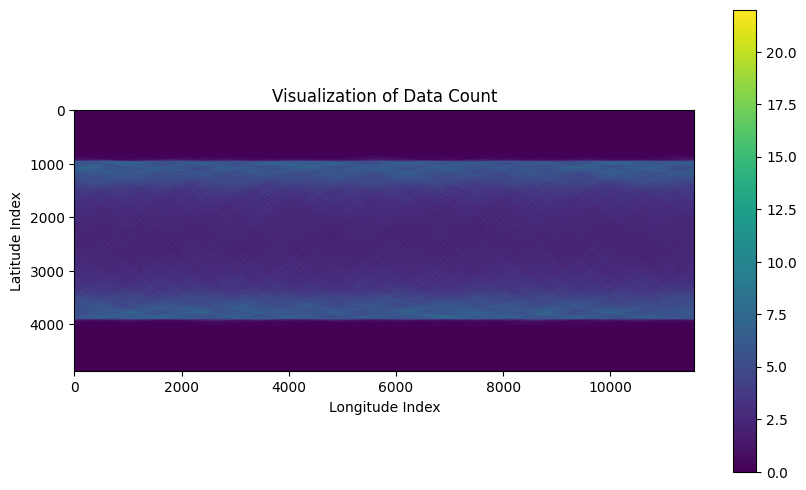

In [9]:
plt.figure(figsize=(10, 6))
im = plt.imshow(data_count, cmap='viridis')
#im = plt.imshow(mean_angles, cmap='viridis')
plt.colorbar(im)
plt.title("Visualization of Data Count")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [ ]:
# Initialize arrays for accumulating sums and counts
angle_sum = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
angle_sum_sq = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
data_count = np.zeros_like(ref_lat, dtype=int)  # Count of measurements for each grid cell

for i, file_name in tqdm(enumerate(nc_file_list[:500]), total=len(nc_file_list[:500]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()

    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Update sums, sum of squares, and counts for each point
    for row, col, angle in zip(rows, cols, sp_inc_angle):
        angle_sum[row, col] += angle
        angle_sum_sq[row, col] += angle ** 2
        data_count[row, col] += 1

Processing Files:  64%|████████████████████████▉              | 319/500 [09:18<06:35,  2.18s/it]

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_53550/2551886561.py:2: RuntimeWarning: invalid value encountered in divide
  variance = (angle_sum_sq / data_count) - (angle_sum / data_count) ** 2


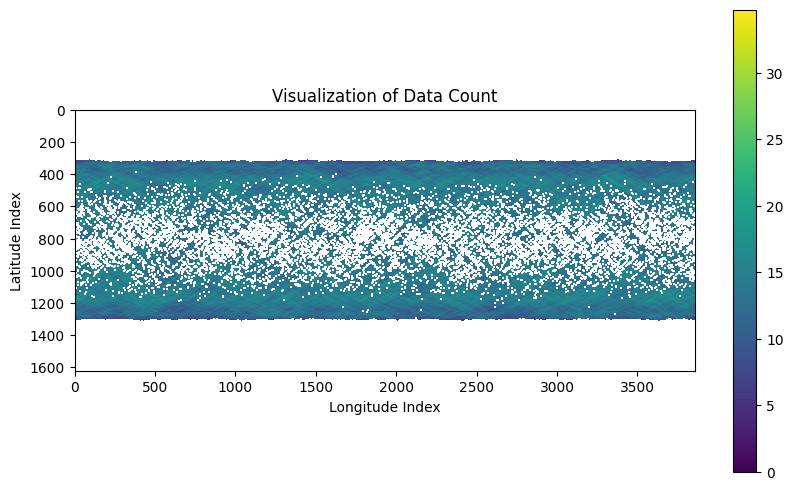

In [49]:
plt.figure(figsize=(10, 6))
variance = (angle_sum_sq / data_count) - (angle_sum / data_count) ** 2
std_deviation = np.sqrt(variance)
#im = plt.imshow(angle_sum/data_count, cmap='viridis')
#im = plt.imshow((angle_sum_sq/data_count) - (angle_sum / data_count)**2, cmap='viridis')
im = plt.imshow(std_deviation, cmap='viridis')
plt.colorbar(im)
plt.title("Visualization of Data Count")
plt.xlabel("Longitude Index")
plt.ylabel("Latitude Index")
plt.show()

In [28]:
# Initialize a dictionary to hold lists of sp_inc_angle values for each grid cell
from collections import defaultdict
angle_data = defaultdict(list)

for i, file_name in tqdm(enumerate(nc_file_list[:10]), total=len(nc_file_list[:10]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    # Extract latitude, longitude, and incidence angle
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()

    # Stack satellite latitudes and longitudes
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)

    # Get the row and column indices in the reference grid
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    # Store sp_inc_angle values in the dictionary
    for idx, angle in zip(indices, sp_inc_angle):
        angle_data[idx].append(angle)

Processing Files: 100%|█████████████████████████████████████████| 10/10 [00:02<00:00,  3.38it/s]


In [ ]:
mean_angles = {idx: np.mean(angles) for idx, angles in angle_data.items()}

In [ ]:
plt.hist(angle_data[97857])

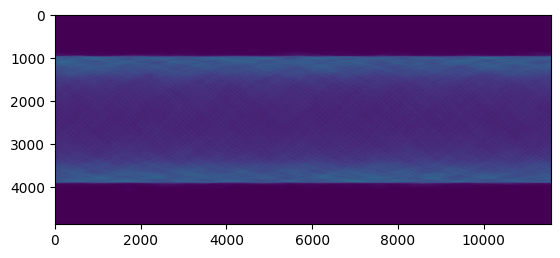

In [7]:
plt.imshow(data_count)